In [1]:
import torch
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path="../"
sys.path.append(path)
import Preprocessing as hsa_preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg

from PIL import Image
from loguru import logger
import Model as hsa_model
import DataLoader as hsa_dataloader
import Viz as hsa_viz
from torch.utils.data import DataLoader


Read Images and plot shape of np.array associated with it. 

In [2]:
image_path= "./night_sky2.jpeg"
img = Image.open(image_path)
array = np.array(img)
print(f"array shape: {array.shape}")

array shape: (1280, 1280, 3)


Plot images of the RGB spectra and original data as np before conversion to df. 

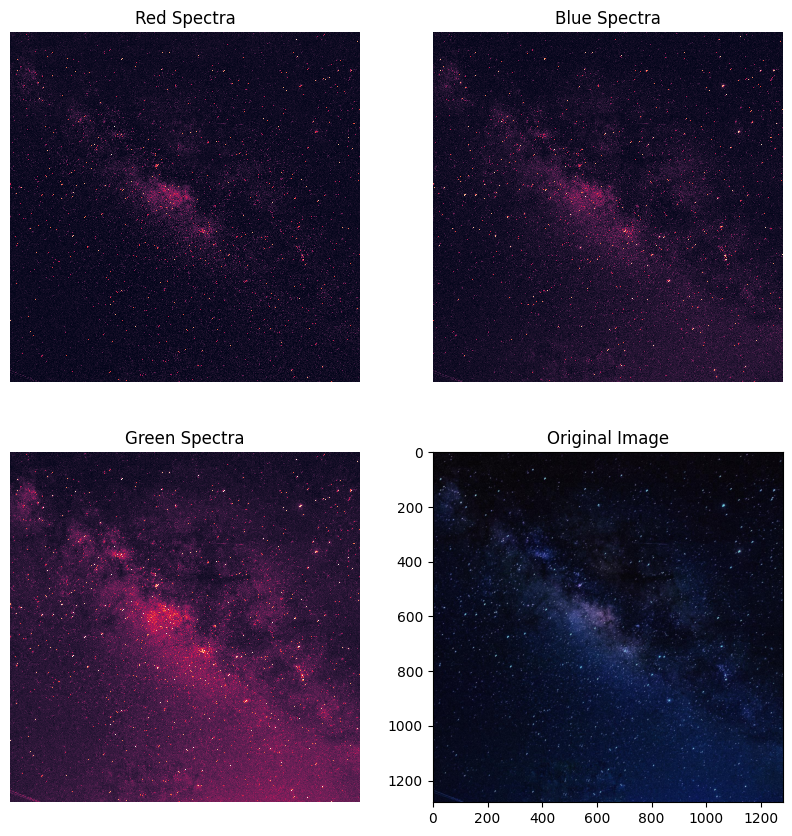

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
titles= ["Red Spectra", "Blue Spectra","Green Spectra", "Original Image"]
for i, ax in enumerate(axs.flat):
    try:
        sns.heatmap(array[:,:,i], square=True, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
        ax.set_title(titles[i])
    except:
        ax.set_title(titles[i])
        image = mpimg.imread(image_path)
        ax.imshow(image)

Generate a list of data points from image and convert to df to begin vanilla preprocessing.

In [4]:
data = None
columns = ["red", "green", "blue"]

for row in range(len(array)):
    try:
        data = np.append(data, array[row, : , :], axis=0)
    except:
        data = array[row, : , :]
 
scaler = StandardScaler()
scaler.fit(data)
preprocessed_df = pd.DataFrame(scaler.transform(data), columns=columns)

Instantiate the model and dataloader with preprocessed data as a np.array()

In [5]:
anomaly_std_toll= 1.2
penalty_ratio=.8
cutoff_dist=2.1
model = hsa_model.HSI_model(
            penalty_ratio=penalty_ratio,
            cutoff_dist= cutoff_dist,
            converge_toll= 1e-5,
            anomaly_std_toll= anomaly_std_toll,
            affinity_matrix_iterations= 20,
            lr= 2.7,
            logger=logger,
            multifilter_flag=0,
        )
dataset = hsa_dataloader.HSI_dataset(preprocessed_np=preprocessed_df.to_numpy(), logger=logger)
dataloader = DataLoader(dataset, batch_size=10)


2025-05-28 11:14:04.561 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.


In [6]:
base_directory = "Images/"
log_directory = f"{base_directory}/logs/"
results_directory = f"{base_directory}/results/"
model.set_directories(log_directory, results_directory)

logger.info("Starting to run through the dataloader on initial pass.")
num_samples = 1000
unique_id_str = "test"
iterations = 10000

for i, data in enumerate(dataloader):  # setting up gpus
    model.set_trial(i * num_samples, num_samples, unique_id_str)
    # Model set up and weight generation
    model.readData(
        data_multifilter_df=data.squeeze(0)
    ).vertWeights_distances().affinityGen().graphEvo()
    # Training steps
    model.torch_optimize_POF(iterations=iterations)
    # Prediction step
    model.model_Predictions(preprocessed_df)
    # Store anomalous predictions throughout all batches for use in multi filter
    try:
        total_anomaly_index = np.append(total_anomaly_index, model.x_label)
    except: 
        total_anomaly_index = model.x_label
        print(f"only on 0 :{i}")
    if i > 1000:
        print(i)
        break
        

2025-05-28 11:14:04.569 | INFO     | __main__:<module>:6 - Starting to run through the dataloader on initial pass.
2025-05-28 11:14:04.570 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:04.572 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:04.572 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:04.573 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
/Users/analyst/Desktop/hsi-partnersite/HSA_venv/lib/python3.11/site-packages/torch/_dynamo/variables/functions.py:1262: UserWarning: Dynamo does not know how to trace the builtin `torch._C._dynamo.guards.assert_size_stride.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C

only on 0 :0


2025-05-28 11:14:07.180 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:07.181 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:07.181 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:07.182 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:07.182 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:07.182 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:07.186 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:07.186 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:07.187 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:07.187 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:07.187 | DEBUG    | Model:affinit

1001


In [7]:
mix_index, mix_data, anomaly_index = model.global_collect_multifilter_df(
            preprocessed_df.to_numpy(),
            total_anomaly_index[: len(preprocessed_df.to_numpy())].astype(int),
            mf_num_samples=9 * len(total_anomaly_index),
        )
anomaly_pred_freq_df = pd.DataFrame()
anomaly_pred_freq_df["User DF Index"] = anomaly_index
anomaly_pred_freq_df.set_index("User DF Index")
anomaly_pred_freq_df["Anom Pred Count"] = np.zeros(len(anomaly_index))

In [8]:
model.uni_shuffle_multifilter_df(
            mix_index.astype(int), mix_data.astype(int), anomaly_index.astype(int)
        )
mf_data = model.all_data
logger.debug(
    "Anomalous data has been colleted into first multifilter dataset."
)

2025-05-28 11:14:16.406 | DEBUG    | __main__:<module>:5 - Anomalous data has been colleted into first multifilter dataset.


In [9]:
print(f"Original data input- preprocessed_df: {preprocessed_df.shape} \nFirst rank anomlus predictions- anomaly_pred_freq_df:{anomaly_pred_freq_df.shape} \nMultifilter data shape- mf_data: {mf_data.shape}")

Original data input- preprocessed_df: (1638400, 3) 
First rank anomlus predictions- anomaly_pred_freq_df:(2703, 2) 
Multifilter data shape- mf_data: (27030, 3)


In [10]:
multi_filters = 5
user_location = model.all_index_user

for i in range(multi_filters):
    batch_dataset = hsa_dataloader.HSI_dataset(mf_data, logger)
    batch_loader = DataLoader(
        batch_dataset, batch_size=num_samples, 
    )
    j = 0
    for data in batch_loader:
        print(data.shape)
        # # Set up multi filter model
        MF_model = hsa_model.HSI_model(
            penalty_ratio=penalty_ratio,
            cutoff_dist= cutoff_dist,
            converge_toll= 1e-5,
            anomaly_std_toll= anomaly_std_toll,
            affinity_matrix_iterations= 20,
            lr= 2.7,
            logger=logger,
            multifilter_flag=1,
        )
        MF_model.set_directories(
            log_directory, results_directory
        )
        MF_model.set_trial(j * len(data), len(data), unique_id_str)
        MF_model.readData(
            data_multifilter_df=data.squeeze(0)
        ).vertWeights_distances().affinityGen().graphEvo()

        # # Train MF_MODEL
        MF_model.torch_optimize_POF(iterations=iterations)
        MF_model.model_Predictions(
            preprocessed_df, multifilter_flag=1, user_location=user_location
        )
        j += 1
        if j > 3:
            break
        anomaly_pred_freq_df.loc[
            anomaly_pred_freq_df["User DF Index"].isin(MF_model.x_label),
            "Anom Pred Count",
        ] += 1

        logger.trace(
            f"Multifilter {i} of {multi_filters} multifilters is complete."
        )
        # # Global multifilter
        mix_index, mix_data, anomaly_index = (
            model.global_collect_multifilter_df(
                preprocessed_df.to_numpy(),
                total_anomaly_index[: len(preprocessed_df.to_numpy())].astype(int),
                mf_num_samples=9 * len(total_anomaly_index),
            )
        )
        MF_model.uni_shuffle_multifilter_df(mix_index, mix_data, anomaly_index)
        mf_data = MF_model.all_data
        user_location = MF_model.all_index_user

2025-05-28 11:14:16.418 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:16.419 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:16.431 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:16.453 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.


torch.Size([1000, 3])


2025-05-28 11:14:16.616 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
/Users/analyst/Desktop/hsi-partnersite/HSA_venv/lib/python3.11/site-packages/torch/_dynamo/variables/functions.py:1262: UserWarning: Dynamo does not know how to trace the builtin `cmpdjzv6vdvo7wes4ffmrrqhkenae2o5ha7ri6ab2usx5nitunt3.kernel.kernel.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use `torch.compiler.allow_in_graph`.
  torch._dynamo.utils.warn_once(explanation + "\n" + "\n".join(hints))
/Users/analyst/Desktop/hsi-partnersite/HSA_venv/lib/pytho

torch.Size([1000, 3])


2025-05-28 11:14:17.338 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:17.339 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:17.429 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:17.437 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:17.444 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:17.464 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:17.615 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:17.621 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:17.622 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.


torch.Size([1000, 3])


2025-05-28 11:14:17.716 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:17.726 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:17.734 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:17.755 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:17.901 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:17.907 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:17.908 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:17.910 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.


torch.Size([1000, 3])
torch.Size([1000, 3])


2025-05-28 11:14:17.919 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:17.926 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:17.945 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:18.094 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:18.100 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:18.101 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:18.192 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:18.201 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:18.209 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:18.230 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:18.381 | DEBUG    | Model:graphEvo:178 - HSI Graph Theo

torch.Size([1000, 3])


2025-05-28 11:14:18.478 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:18.489 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:18.497 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:18.516 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:18.663 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:18.669 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:18.669 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.


torch.Size([1000, 3])


2025-05-28 11:14:18.764 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:18.775 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:18.783 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:18.803 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:18.950 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:18.956 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:18.957 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:18.959 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.


torch.Size([1000, 3])
torch.Size([1000, 3])


2025-05-28 11:14:18.970 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:18.977 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:18.997 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:19.145 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:19.151 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:19.152 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:19.241 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:19.252 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:19.260 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:19.281 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:19.436 | DEBUG    | Model:graphEvo:178 - HSI Graph Theo

torch.Size([1000, 3])


2025-05-28 11:14:19.443 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:19.443 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:19.535 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:19.546 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:19.553 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:19.573 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:19.721 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:19.727 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:19.728 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.


torch.Size([1000, 3])


2025-05-28 11:14:19.819 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:19.830 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:19.838 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:19.857 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:20.004 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:20.010 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:20.010 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:20.013 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.


torch.Size([1000, 3])
torch.Size([1000, 3])


2025-05-28 11:14:20.025 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:20.032 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:20.051 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:20.199 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:20.205 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:20.205 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:20.297 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:20.310 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:20.317 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:20.336 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:20.483 | DEBUG    | Model:graphEvo:178 - HSI Graph Theo

torch.Size([1000, 3])


2025-05-28 11:14:20.582 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:20.595 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:20.635 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:20.658 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.


torch.Size([1000, 3])


2025-05-28 11:14:20.809 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:20.815 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:20.816 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:20.908 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:20.918 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:20.925 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:20.945 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:21.095 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:21.100 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:21.101 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:21.103 | WARNING  | Model:get_free_gpu:40 - 

torch.Size([1000, 3])
torch.Size([1000, 3])


2025-05-28 11:14:21.112 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:21.119 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:21.139 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:21.285 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:21.291 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:21.292 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.
2025-05-28 11:14:21.383 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:21.393 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:21.401 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:21.420 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:21.572 | DEBUG    | Model:graphEvo:178 - HSI Graph Theo

torch.Size([1000, 3])


2025-05-28 11:14:21.668 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:21.676 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:21.684 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:21.703 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:21.849 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:21.855 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:21.856 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.


torch.Size([1000, 3])


2025-05-28 11:14:21.948 | WARNING  | Model:get_free_gpu:40 - No GPU available, running on CPU.
2025-05-28 11:14:21.959 | DEBUG    | Model:readData:101 - Initial random anomaly index set.
2025-05-28 11:14:21.967 | DEBUG    | Model:vertWeights_distances:133 - HSI Model Weight Generated.
2025-05-28 11:14:21.987 | DEBUG    | Model:affinityGen:161 - HSI Graphs generated.
2025-05-28 11:14:22.139 | DEBUG    | Model:graphEvo:178 - HSI Graph Theory complete.
2025-05-28 11:14:22.145 | DEBUG    | Model:torch_optimize_POF:286 - HSI Torch optimization complete.
2025-05-28 11:14:22.146 | DEBUG    | Model:model_Predictions:323 - HSI model predictions complete.


torch.Size([1000, 3])


2025-05-28 11:16:37.891 | DEBUG    | Viz:heatmap_bin_predictions_vert:161 - heatmap_bin_predictions_vert was generated. The save_fig=0.


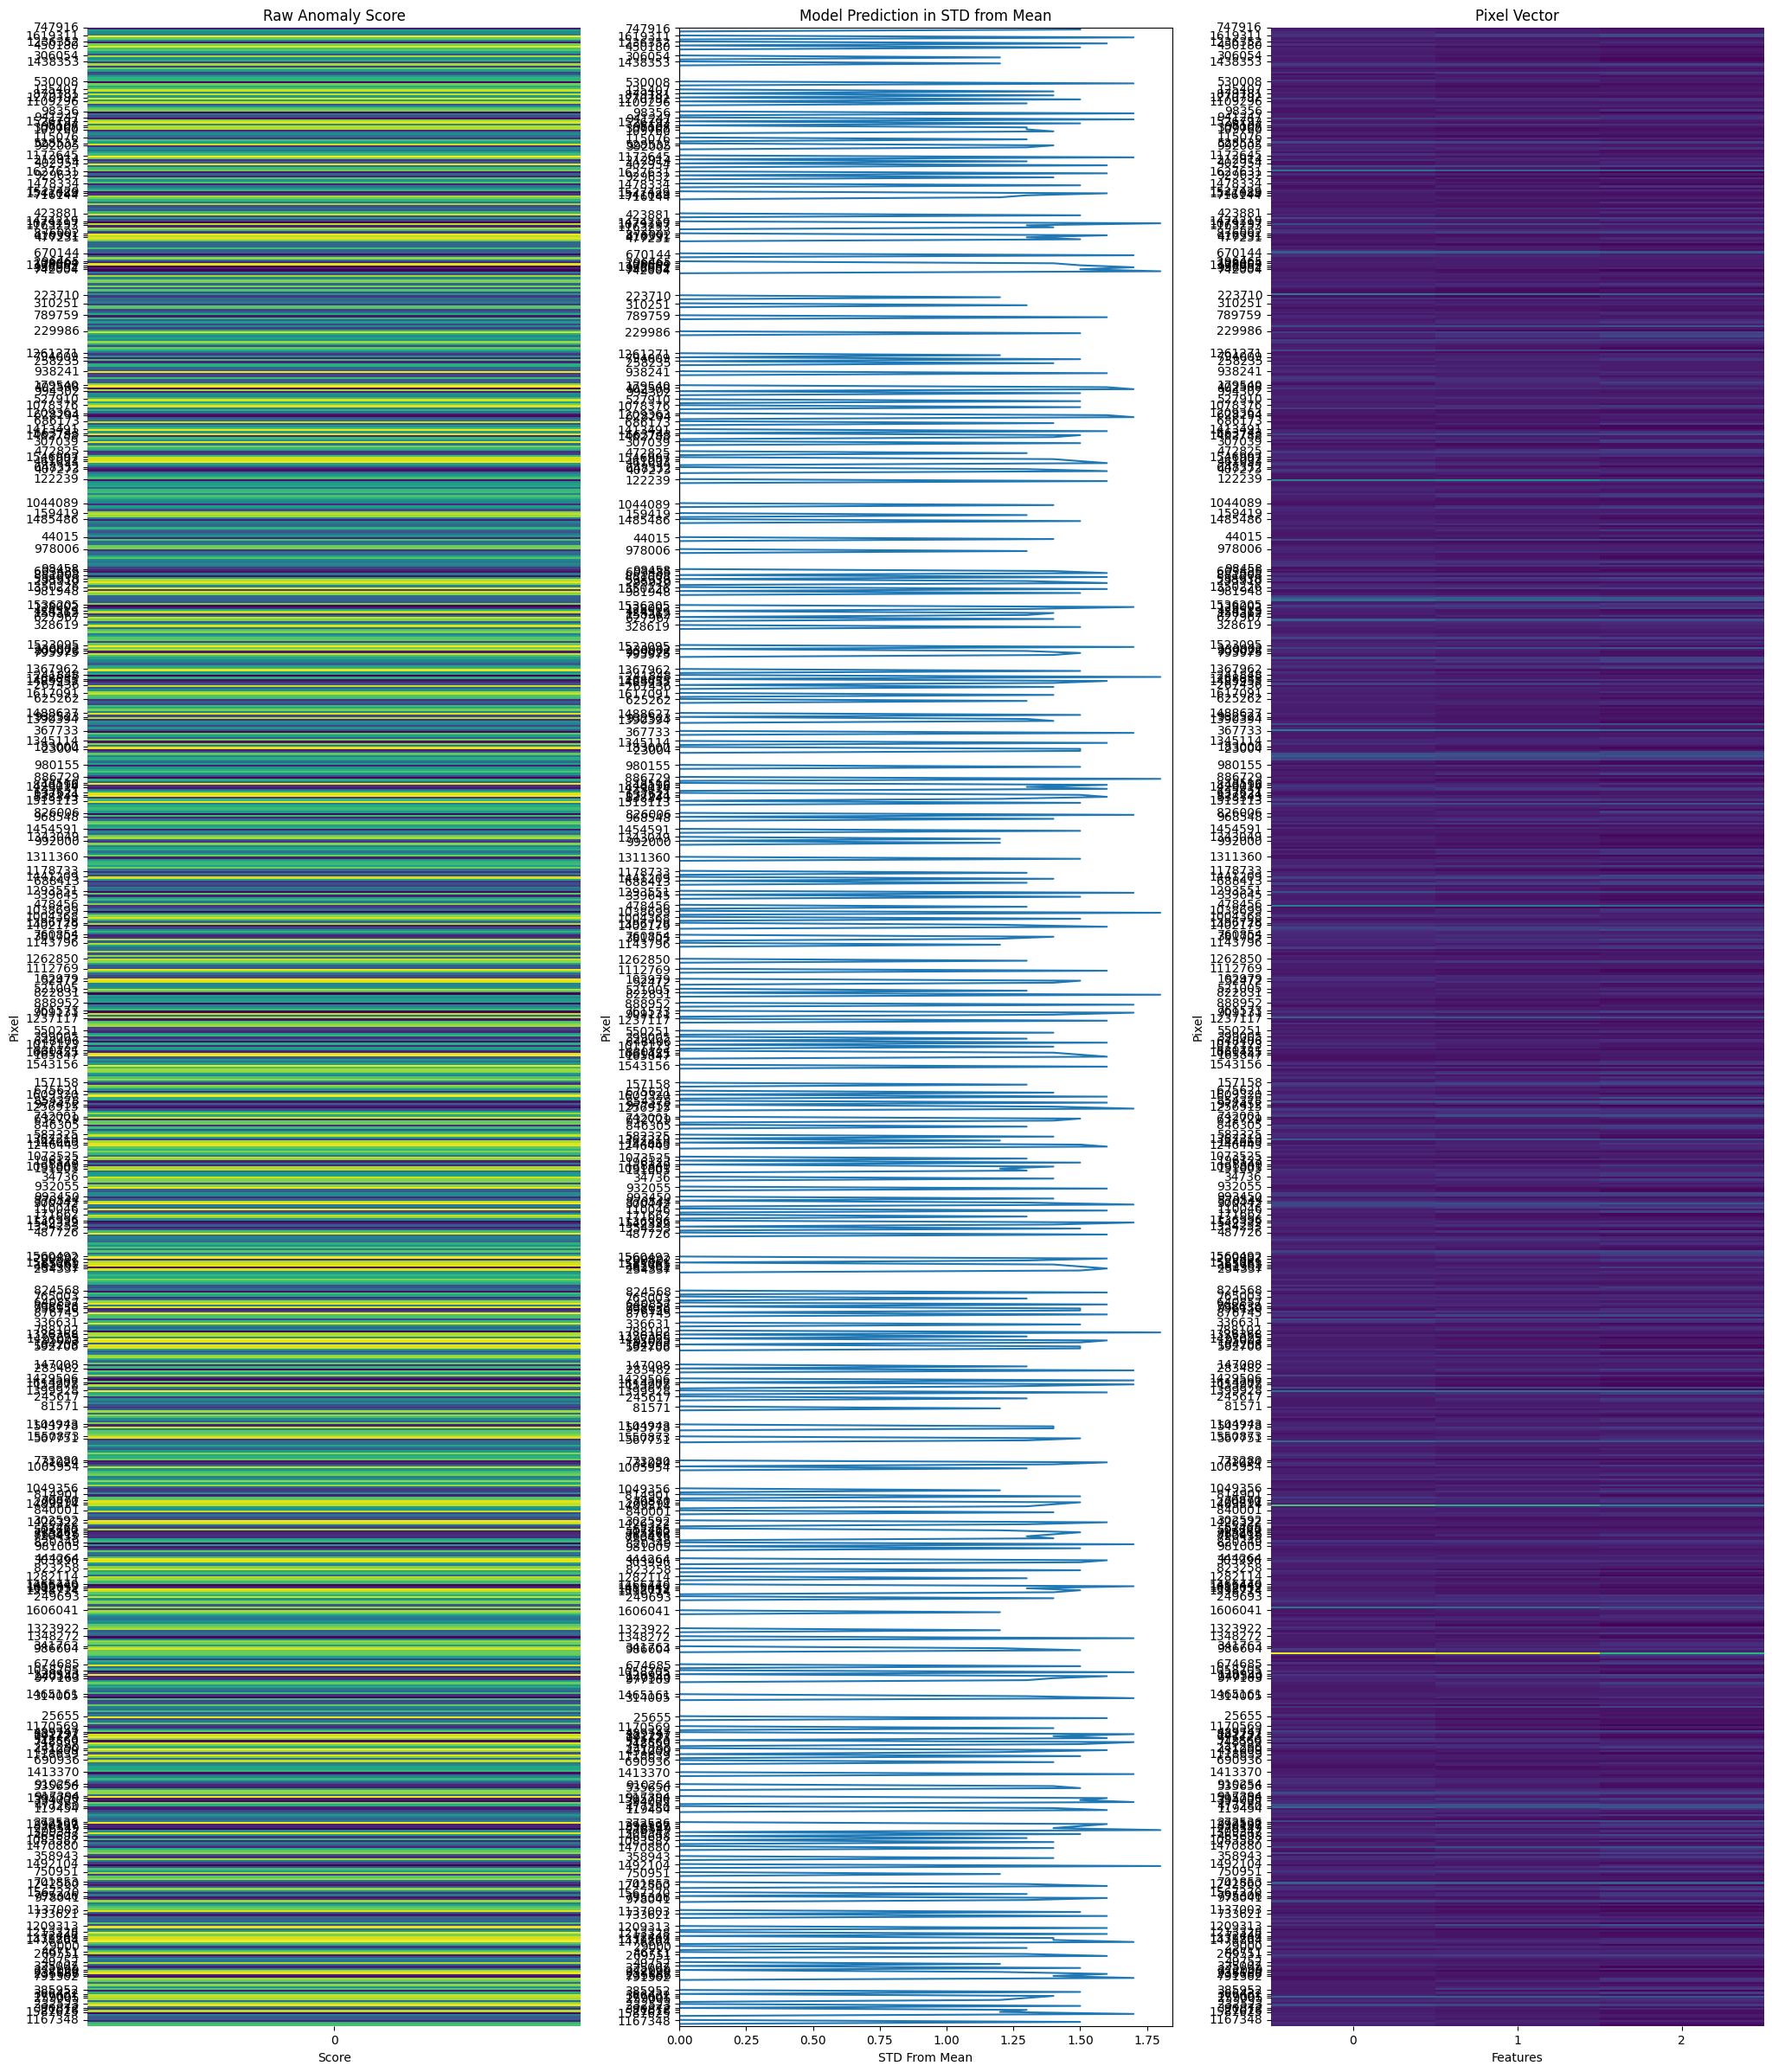

In [16]:
viz = hsa_viz.HSI_viz(
    MF_model.m,
    MF_model.preprocessed_np,
    num_samples,
    0,
    0,
    1,
    0,
    "plot_directory",
    "unique_id_str",
    logger,
)
viz.heatmap_bin_predictions_vert(
    0,
    MF_model.bin_score,
    MF_model.x_ticks,
    MF_model.x_label,
)


In [12]:
anomaly_pred_freq_df.head()

,User DF Index,Anom Pred Count
0,1,0.0
1,3,0.0
2,6,0.0
3,1000,0.0
4,1004,0.0


In [13]:
anomaly_pred_freq_df[anomaly_pred_freq_df["Anom Pred Count"]>0]

,User DF Index,Anom Pred Count
8,3008,1.0
9,3009,1.0
26,9005,1.0
33,11007,1.0
34,12002,2.0
...,...,...
2662,988003,1.0
2679,993006,1.0
2682,994003,1.0
2686,995005,1.0


In [14]:
anomaly_pred_freq_df[anomaly_pred_freq_df["Anom Pred Count"]>0]

,User DF Index,Anom Pred Count
8,3008,1.0
9,3009,1.0
26,9005,1.0
33,11007,1.0
34,12002,2.0
...,...,...
2662,988003,1.0
2679,993006,1.0
2682,994003,1.0
2686,995005,1.0
